# Replicate Screen & Deser for all CMIP5 and CMIP6 Large Ensembles

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patheffects as pe
import numpy as np
import scipy.stats as stats
import datetime
import glob
import re
print(datetime.datetime.now())

2024-02-15 17:58:22.284992


In [2]:
model_names = [
    'ACCESS-ESM1-5', 'CanESM5', 'CESM2-LENS', 'CESM2-LENS-SMBB', 'EC-Earth3',
    'MIROC6', 'MPI-ESM1-2-LR', 'CanESM2', 'CESM1', 'GFDL-ESM2M', 'MPI-ESM1',
]

model_years = {
    'CanESM5':[1850,2100], 'CESM2-LENS':[1850,2100], 'CESM2-LENS-SMBB':[1850,2100], 
    'ACCESS-ESM1-5':[1850,2100], 'MPI-ESM1-2-LR':[1850,2100], 'MIROC6':[1850,2100], 
    'EC-Earth3':[1850,2100], 'CanESM2':[1950,2100], 'CESM1':[1920,2100], 
    'GFDL-ESM2M':[1950,2100], 'MPI-ESM1':[1850,2099], 
}

model_colors = {
    'CanESM5':'m', 'CESM2-LENS':'b', 'CESM2-LENS-SMBB':'c', 
    'ACCESS-ESM1-5':'olive', 'MPI-ESM1-2-LR':'orange', 'MIROC6':'tab:brown', 
    'EC-Earth3':'g', 'CanESM2':'tab:purple', 'CESM1':'tab:blue', 
    'GFDL-ESM2M':'brown', 'MPI-ESM1':'tab:orange', 
}

SIE_mem = {
    'CanESM5':50, 'CESM2-LENS':50, 'CESM2-LENS-SMBB':50, 'ACCESS-ESM1-5':40, 
    'MPI-ESM1-2-LR':30,'MIROC6':50, 'EC-Earth3':57, 'CanESM2':50, 'CESM1':40, 
    'GFDL-ESM2M':30, 'MPI-ESM1':100,
}

IPO_mem = {
    'CanESM5':50, 'CESM2-LENS':50, 'CESM2-LENS-SMBB':50, 'ACCESS-ESM1-5':40, 
    'MPI-ESM1-2-LR':30, 'MIROC6':50, 'EC-Earth3':50, 'CanESM2':50, 'CESM1':40, 
    'GFDL-ESM2M':30, 'MPI-ESM1':70,
}

CVDP_mem_n = {
    'CanESM5':50, 'CESM2-LENS':50, 'CESM2-LENS-SMBB':50, 'ACCESS-ESM1-5':40, 
    'MPI-ESM1-2-LR':30, 'MIROC6':50, 'EC-Earth3':50, 'CanESM2':40, 'CESM1':40, 
    'GFDL-ESM2M':30, 'MPI-ESM1':70,
}


CMIP5_model_name_conversion = {
    'CanESM2':'CanESM2', 'CESM1':'CESM1', 'GFDL-ESM2M':'GFDL_ESM2M',
    'MPI-ESM1':'MPI_ESM1'
}

CMIP5_model_centers = {
    'CanESM2':'CCCma', 'CESM1':'NCAR', 'GFDL-ESM2M':'GFDL-ESM2M', 
    'MPI-ESM1':'MPI'
}

## Load the SIE data

In [10]:
#load the September SIE - N.B. CHANGE VARIABLE FOR SIA OR SIE!!!!!!!
sep_SIE = {}

for model_name in model_names:
    print(model_name)
        
    model_SIE = []
    mem_list = []
    for file in np.sort(glob.glob('/glade/work/cwpowell/ice-free/sea_ice_data/'
                                  f'SIA_SIE_{model_name}_*.nc')):

        mem_temp = file.split(f'SIA_SIE_{model_name}_',1)[1]
        mem_list.append(mem_temp.split('_historical')[0])

        model_SIE.append(xr.open_dataset(file)['Arctic_SIE'])

    model_SIE = xr.concat((model_SIE),dim='member')
    model_SIE['member'] = mem_list
    model_SIE = model_SIE.sel(time=model_SIE['time.month']==9)
    model_SIE['time'] = np.arange(model_years[model_name][0],
                                  model_years[model_name][1]+1)
    
    sep_SIE[model_name] = model_SIE
    
#compute a rolling 11 year average
sep_SIE_11yr = {}

for model_name in model_names:
    sep_SIE_11yr[model_name] = sep_SIE[model_name].rolling(
        time=11, center=True).mean()

ACCESS-ESM1-5
CanESM5
CESM2-LENS
CESM2-LENS-SMBB
EC-Earth3
MIROC6
MPI-ESM1-2-LR
CanESM2
CESM1
GFDL-ESM2M
MPI-ESM1


In [11]:
#load the NSIDC sea ice index (version 3) September sea ice areas for 1979-2022
#(with pole hole added)
SII_SIE_09 = xr.DataArray(
    data = [
        8.24, 8.86, 8.33, 8.49, 8.58, 8, 7.89, 8.6, 7.59, 7.68, 7.32, 6.45, 
        6.78, 7.78, 6.71, 7.45, 6.39, 7.89, 7, 6.85, 6.43, 6.56, 7.04, 6.14, 
        6.43, 6.29,5.81, 6.17, 4.58, 4.719, 5.289, 4.899, 4.589, 3.599, 5.239, 
        5.249, 4.649, 4.559, 4.849, 4.819, 4.389, 4.029, 4.979, 4.929, 4.399],
    dims = ['year'], 
    coords = {'year':np.arange(1979,2024)}
)
print('unrounded value 2007-2017', SII_SIE_09.sel(year=slice(2007,2017)).mean().values)
print('unrounded value 2013-2023', SII_SIE_09.sel(year=slice(2013,2023)).mean().values)

obs_11yr = 4.667 #S&D quote 4.7

unrounded value 2007-2017 4.747272727272727
unrounded value 2013-2023 4.735363636363636


In [4]:
#alternatively load SIA instead
SII_SIE_09 = xr.DataArray(
    data = [
    5.77,6.06,5.63,5.62,5.89,5.3,5.42,5.91,5.95,5.67,5.17,4.86,4.82,5.74,4.89,
    5.44,4.74,5.93,5.2,4.61,4.6,4.66,4.9,4.34,4.36,4.7,4.38,4.32,3.13,3.289,
    3.789,3.369,3.239,2.439,3.809,3.769,3.449,2.939,3.379,3.379,3.199,2.859,
    3.499,3.499,],
    dims = ['year'], 
    coords = {'year':np.arange(1979,2023)}
)

print('unrounded value', SII_SIE_09.sel(year=slice(2007,2017)).mean().values)

obs_11yr = #3.32

unrounded value 3.3272727272727276


In [14]:
#calculate trajectory years starting from the closest year to the selected 
#pan-Arctic SIA, cut off at 1970 to avoid 1942 being selected for
#CESM2-LENS member 1301.010 and 1950s/1960s dips for CanESM2
traj_start_yr = {}
for model_name in model_names:
    data = sep_SIE_11yr[model_name].sel(time=slice('1960','2100'))
    ranked_SIE = xr.ufuncs.fabs(data-obs_11yr).rank('time')
    ranked_SIE_years = ranked_SIE.where(ranked_SIE==1)
    traj_start_yr[model_name] = ranked_SIE['time'].where(
        ranked_SIE_years==1).max('time')

In [27]:
reduced_model_names = ['ACCESS-ESM1-5', 'CanESM5', 'CESM2-LENS', 'EC-Earth3',
     'MIROC6', 'MPI-ESM1-2-LR', 'CanESM2', 'CESM1'][::-1]

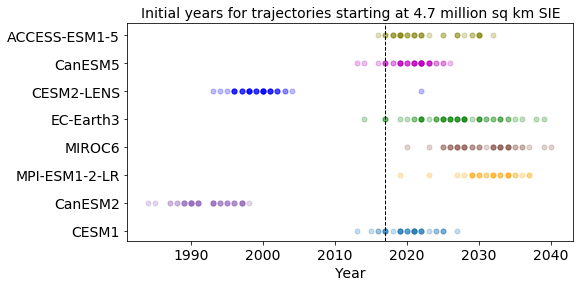

In [31]:
#make a plot of trajectory starting years
fig = plt.figure(figsize=[8,4])
# for model_i, model_name in enumerate(np.sort(list(traj_start_yr.keys()))):
for model_i, model_name in enumerate(reduced_model_names):
    data = traj_start_yr[model_name]

    plt.scatter(traj_start_yr[model_name], np.ones(len(data))*model_i, 
                color=model_colors[model_name], s=25, alpha=0.25)
    
# plt.yticks(range(11), np.sort(list(traj_start_yr.keys())));
plt.yticks(range(8), reduced_model_names);
plt.axvline(2017, c='k', linewidth=1, linestyle='--');
plt.title(f'Initial years for trajectories starting at {round(obs_11yr,1)} million sq km SIE', fontsize=14);
# plt.xlim(1980,2042);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Year',fontsize=14);
fig.savefig('/glade/work/cwpowell/ice-free/figures/Intial_years_SIE_47.pdf',bbox_inches='tight')

In [7]:
SIE_traj = {}

for model_name in model_names:
    
    model_SIE_traj = []
    for mem_ in np.sort(sep_SIE_11yr[model_name]['member']):

        data = sep_SIE_11yr[model_name].sel(member=mem_)
        start_yr = int(traj_start_yr[model_name].sel(member=mem_).values)
        
        traj_data = data.sel(time=slice(str(start_yr),str(start_yr+50)))
        traj_data['time'] = np.arange(0,51)              
        model_SIE_traj.append(traj_data)

    model_SIE_traj = xr.concat((model_SIE_traj),dim='member')
    model_SIE_traj['member'] = np.sort(sep_SIE_11yr[model_name]['member'])
    SIE_traj[model_name] = model_SIE_traj

## Load the IPO data

In [8]:
all_TPI = {}

base_path = '/glade/work/cwpowell/low-freq-trajectories/SST_for_IPO/IPO_per_Screen_Deser/'
# base_path = '/glade/work/cwpowell/ice-free/IPO/'

file_name = '_11yr_annual_av_TPI_filtered_11yr_Lanczos.nc'#'_11yr_annual_av_TPI_13yr_Lanczos_filter.nc'
# file_name = '_annual_11yr_TPI.nc'

for model_name in model_names:
    if model_name == 'CESM2-LENS-SMBB':
        all_TPI[model_name] = xr.open_dataarray(
            base_path+'CESM2-LENS'+file_name)
    
    elif model_name in ['CanESM2', 'CESM1', 'GFDL-ESM2M', 'MPI-ESM1']:
        temp = xr.open_dataarray(base_path+model_name+file_name)
        
        if model_name == 'MPI-ESM1':
            temp['member'] = ['r{}i2005p3'.format(str(mem_).zfill(3))
                              for mem_ in temp['member'].values]
        else:
            temp['member'] = [f'r{mem_}i1p1' for mem_ in temp['member'].values]
            
        all_TPI[model_name] = temp.sortby('member')
    
    else:
        all_TPI[model_name] = xr.open_dataarray(base_path+model_name+file_name)


In [78]:
#Alternatively load the IPO as calculated by the CVDP
all_TPI = {}

for model_name in model_names:
    print(datetime.datetime.now(), model_name)
    
    all_mem = []
    mem_used = []
    
    for mem_ in traj_start_yr[model_name]['member'].values:
        
        try:
        
            if model_name in ['CanESM2', 'CESM1', 'GFDL-ESM2M', 'MPI-ESM1']:
                
                mem_num = int(re.findall('r(.*)i',mem_)[0])
                
                CVDP_mem = xr.open_dataset(
                    '/glade/work/cwpowell/ice-free/raw_CVDP/CMIP5_hist_rcp85/'
                    f'{CMIP5_model_centers[model_name]}_#{mem_num}.cvdp_data.'\
                    '1950-2099.nc', decode_times=False)['ipo_timeseries_mon']

                CVDP_mem['time'] = np.arange('1950-01', '2100-01',
                                             dtype='datetime64[M]')
            else:
                if model_name == 'CESM2-LENS-SMBB':
                    model_name_ = 'CESM2-LENS'
                else:
                    model_name_ = model_name

                if (model_name == 'EC-Earth3') and (mem_[4] == 'i'):
                    end_str_hist = '.ipo.1970'
                    end_str_fut =  '.ipo.2015'
                    start_yr = '1970'
                else:
                    end_str_hist = '.1920'
                    end_str_fut =  '.2015'
                    start_yr = '1920'

                CVDP_mem_hist = xr.open_dataset(
                    '/glade/work/cwpowell/ice-free/raw_CVDP/CMIP6_hist/'\
                    f'{model_name_}_{mem_}.cvdp_data{end_str_hist}-2014.nc', 
                    decode_times=False)['ipo_timeseries_mon']

                CVDP_mem_fut = xr.open_dataset(
                    '/glade/work/cwpowell/ice-free/raw_CVDP/CMIP6_ssp370/'\
                    f'{model_name_}_{mem_}.cvdp_data{end_str_fut}-2100.nc', 
                    decode_times=False)['ipo_timeseries_mon']

                CVDP_mem = xr.concat((CVDP_mem_hist,CVDP_mem_fut), dim='time')

                CVDP_mem['time'] = np.arange(f'{start_yr}-01', '2101-01', 
                                             dtype='datetime64[M]')
                
            mem_used.append(mem_)
            all_mem.append(CVDP_mem)
        
        except FileNotFoundError:
            print(model_name, mem_, 'no CVDP data')

    all_mem = xr.concat((all_mem),dim='member')
    all_mem['member'] = mem_used
    
    #now take the annual average
    all_mem = all_mem.groupby('time.year').mean()
    
    #remove ensemble mean (so no need to linearly detrend)
    all_mem = all_mem - all_mem.mean('member')
    
    if model_name in ['CanESM2', 'CESM1', 'GFDL-ESM2M', 'MPI-ESM1']:
        all_mem = all_mem / all_mem.std('year').mean('member')
    
    else: #the historical and future periods have different variances
        all_mem_hist = all_mem.sel(year=slice('1920','2014')) \
            / all_mem.sel(year=slice('1920','2014')).std('year').mean('member')
        
        all_mem_fut = all_mem.sel(year=slice('2015','2100')) \
            / all_mem.sel(year=slice('2015','2100')).std('year').mean('member')
                          
        all_mem = xr.concat((all_mem_hist, all_mem_fut),dim='year')
        
    #apply an 11-year rolling average, then standardize again
    all_mem = all_mem.rolling(year=11, center=True).mean()
    all_mem = all_mem - all_mem.mean('year').mean('member')
    all_mem = all_mem / all_mem.std('year').mean('member')
        
    all_TPI[model_name] = all_mem

2023-08-23 17:50:39.768925 CESM2-LENS


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_nh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_sh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_nh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_sh_extent_climo' has _Unsigned attribute but is not of int

2023-08-23 17:51:05.174688 CESM2-LENS-SMBB


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_nh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_sh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_nh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_sh_extent_climo' has _Unsigned attribute but is not of int

2023-08-23 17:51:30.525418 EC-Earth3
EC-Earth3 r11i1p1f1 no CVDP data
EC-Earth3 r13i1p1f1 no CVDP data
EC-Earth3 r15i1p1f1 no CVDP data
EC-Earth3 r1i1p1f1 no CVDP data
EC-Earth3 r4i1p1f1 no CVDP data
EC-Earth3 r6i1p1f1 no CVDP data
2023-08-23 17:51:34.759134 MIROC6
2023-08-23 17:51:55.177789 MPI-ESM1-2-LR
2023-08-23 17:52:06.890129 CanESM2


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_nh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_sh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,


CanESM2 r41i1p1 no CVDP data
CanESM2 r42i1p1 no CVDP data
CanESM2 r43i1p1 no CVDP data
CanESM2 r44i1p1 no CVDP data
CanESM2 r45i1p1 no CVDP data
CanESM2 r46i1p1 no CVDP data
CanESM2 r47i1p1 no CVDP data
CanESM2 r48i1p1 no CVDP data
CanESM2 r49i1p1 no CVDP data
CanESM2 r50i1p1 no CVDP data
2023-08-23 17:52:16.112141 CESM1
2023-08-23 17:52:27.452123 GFDL-ESM2M


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_nh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sic_sh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,


2023-08-23 17:52:35.196752 MPI-ESM1
MPI-ESM1 r071i2005p3 no CVDP data
MPI-ESM1 r072i2005p3 no CVDP data
MPI-ESM1 r073i2005p3 no CVDP data
MPI-ESM1 r074i2005p3 no CVDP data
MPI-ESM1 r075i2005p3 no CVDP data
MPI-ESM1 r076i2005p3 no CVDP data
MPI-ESM1 r077i2005p3 no CVDP data
MPI-ESM1 r078i2005p3 no CVDP data
MPI-ESM1 r079i2005p3 no CVDP data
MPI-ESM1 r080i2005p3 no CVDP data
MPI-ESM1 r081i2005p3 no CVDP data
MPI-ESM1 r082i2005p3 no CVDP data
MPI-ESM1 r083i2005p3 no CVDP data
MPI-ESM1 r084i2005p3 no CVDP data
MPI-ESM1 r085i2005p3 no CVDP data
MPI-ESM1 r086i2005p3 no CVDP data
MPI-ESM1 r087i2005p3 no CVDP data
MPI-ESM1 r088i2005p3 no CVDP data
MPI-ESM1 r089i2005p3 no CVDP data
MPI-ESM1 r090i2005p3 no CVDP data
MPI-ESM1 r091i2005p3 no CVDP data
MPI-ESM1 r092i2005p3 no CVDP data
MPI-ESM1 r093i2005p3 no CVDP data
MPI-ESM1 r094i2005p3 no CVDP data
MPI-ESM1 r095i2005p3 no CVDP data
MPI-ESM1 r096i2005p3 no CVDP data
MPI-ESM1 r097i2005p3 no CVDP data
MPI-ESM1 r098i2005p3 no CVDP data
MPI-ESM1 r09

## Calculate the initial IPO trajectories as positive, negative or neurtral

In [9]:
#categorize members by -ve, neutral, +ve
threshold = 0.9 #sigma
IPO_sign = {}

for model_name in model_names:

    var_signs = []

    mem_list = np.sort(traj_start_yr[model_name]['member'])
    
    mem_used = []
    for mem_ in mem_list:
        
        try:
            start_yr = int(traj_start_yr[model_name].sel(member=mem_).values)

            var_value = all_TPI[model_name].sel(member=mem_).sel(
                year=start_yr).values

            if var_value < -threshold: 
                sign = -1
            elif var_value > threshold: 
                sign = 1
            else:
                sign = 0

            var_signs.append(sign)
            mem_used.append(mem_)
        
        except KeyError:
            print(model_name, mem_, 'SIE data but no IPO data')
            

    var_signs = xr.DataArray(
        data = var_signs,
        coords = {'member':mem_used},
        dims = ['member']
    )

    IPO_sign[model_name] = var_signs

EC-Earth3 r11i1p1f1 SIE data but no IPO data
EC-Earth3 r13i1p1f1 SIE data but no IPO data
EC-Earth3 r15i1p1f1 SIE data but no IPO data
EC-Earth3 r1i1p1f1 SIE data but no IPO data
EC-Earth3 r4i1p1f1 SIE data but no IPO data
EC-Earth3 r6i1p1f1 SIE data but no IPO data


## Plot the results

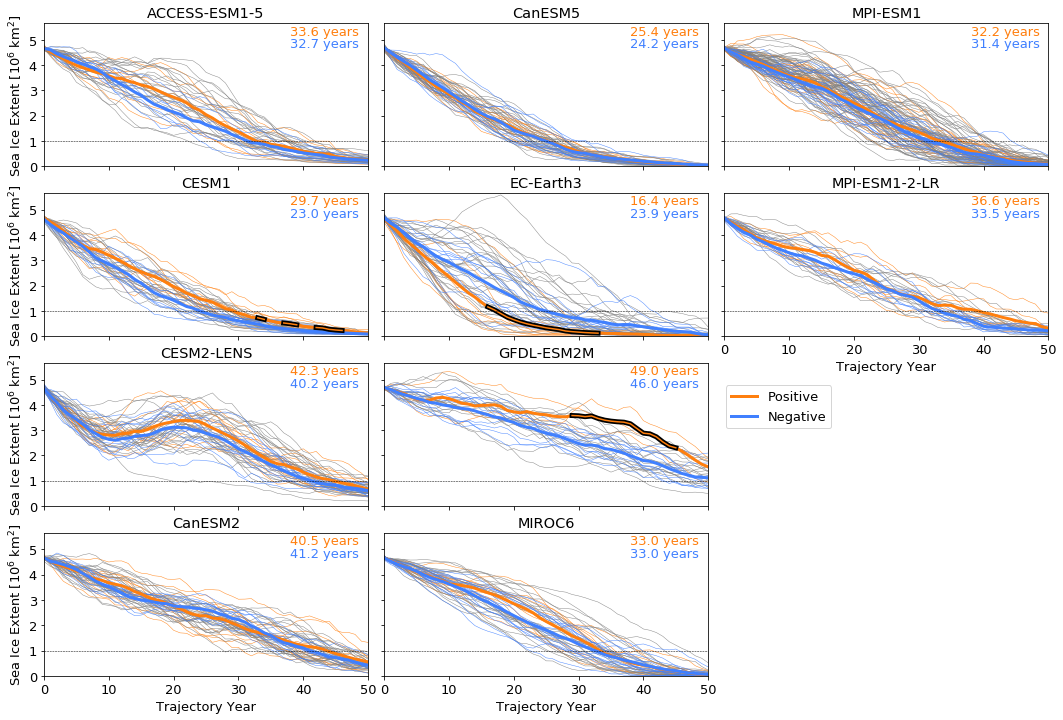

In [20]:
#plot all 11 GCMs' trajectories based on initial IPO phase
pos_col = 'tab:orange'#'tab:orange'
neg_col = [0.25,0.5,1]#'tab:cyan'

fig, axes = plt.subplots(4,3,figsize=[18,12])

for model_i, model_name in enumerate(
    ['ACCESS-ESM1-5','CESM1', 'CESM2-LENS', 'CanESM2', 
     'CanESM5', 'EC-Earth3', 'GFDL-ESM2M', 'MIROC6',
     'MPI-ESM1', 'MPI-ESM1-2-LR']):
    
    ax_y = int(np.floor(model_i / 4))
    ax_x = int(model_i % 4)
    
    pos_mem = IPO_sign[model_name]['member'].where(IPO_sign[model_name]==1, 
                                                   drop=True)
    neu_mem = IPO_sign[model_name]['member'].where(IPO_sign[model_name]==0, 
                                                   drop=True)
    neg_mem = IPO_sign[model_name]['member'].where(IPO_sign[model_name]==-1, 
                                                   drop=True)

    for mem_ in pos_mem:
        axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
            member=mem_), color=pos_col, linewidth=0.5, alpha=0.9)
    for mem_ in neu_mem:
        axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
            member=mem_), color='0.5', linewidth=0.5, alpha=0.9)
    for mem_ in neg_mem:
        axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
            member=mem_), color=neg_col, linewidth=0.5, alpha=0.9)

    #plot the composite for each case
    axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
        member=pos_mem).mean('member'), c=pos_col, linewidth=3, label='Positive')
    axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
        member=neg_mem).mean('member'), c=neg_col, linewidth=3, label='Negative')
    
    #plot a black boarder if statistically significant FROM EACHOTHER
    # t_test = stats.ttest_ind(
    #     SIE_traj[model_name].sel(member=pos_mem),
    #     SIE_traj[model_name].sel(member=neg_mem), axis=0)

    #plot a black boarder if statistically significant FROM MEAN
    t_test_pos = stats.ttest_ind(
        SIE_traj[model_name].sel(member=pos_mem),
        SIE_traj[model_name], axis=0)

    t_test_neg = stats.ttest_ind(
        SIE_traj[model_name].sel(member=neg_mem),
        SIE_traj[model_name], axis=0)
    
   
    axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
        member=pos_mem).mean('member').where(t_test_pos[1]<0.05), c=pos_col,
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
    
    axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
        member=neg_mem).mean('member').where(t_test_neg[1]<0.05), c=neg_col,
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
    
    #plot text for the first crossing of 1 million square km (Ice-Free)
    ranked_less1 = (SIE_traj[model_name]['time'].where(
        SIE_traj[model_name].sel(member=pos_mem)<1).rank('time'))
    IF_pos = SIE_traj[model_name]['time'].where(ranked_less1==1).max(
        'time').mean()
    ranked_less1 = (SIE_traj[model_name]['time'].where(
        SIE_traj[model_name].sel(member=neg_mem)<1).rank('time'))
    IF_neg = SIE_traj[model_name]['time'].where(ranked_less1==1).max(
        'time').mean()
    
    axes[ax_x,ax_y].text(38,5.2,str(np.round(float(IF_pos),1))+' years',
                         color=pos_col, fontsize=13)
    axes[ax_x,ax_y].text(38,4.7,str(np.round(float(IF_neg),1))+' years',
                         color=neg_col, fontsize=13)
    # axes[ax_x,ax_y].text(38,4.1,str(np.round(float(IF_pos),1))+' years',
    #                      color=pos_col, fontsize=13)
    # axes[ax_x,ax_y].text(38,3.6,str(np.round(float(IF_neg),1))+' years',
    #                      color=neg_col, fontsize=13)

    axes[ax_x,ax_y].axhline(1, c='k', linewidth=0.5, linestyle='--')

    axes[ax_x,ax_y].set_xlim(0,50)
    axes[ax_x,ax_y].set_ylim(0,5.65)
    # axes[ax_x,ax_y].set_ylim(0,4.55)
       
    axes[ax_x,ax_y].set_yticks([0,1,2,3,4,5])
    # axes[ax_x,ax_y].set_yticks([0,1,2,3,4])
    if model_i <4:
        axes[ax_x,ax_y].set_yticklabels(['0','1','2','3','4','5'], fontsize=13)
        # axes[ax_x,ax_y].set_yticklabels(['0','1','2','3','4'], fontsize=13)
        axes[ax_x,ax_y].set_ylabel(r'Sea Ice Extent [10$^6$ km$^2$]',
                                   fontsize=13)
        # axes[ax_x,ax_y].set_ylabel(r'Sea Ice Area [10$^6$ km$^2$]',
        #                            fontsize=13)
    else:
        axes[ax_x,ax_y].set_yticklabels([])
        
    if model_i in [3,7,9]:
        axes[ax_x,ax_y].set_xticks([0,10,20,30,40,50])
        axes[ax_x,ax_y].set_xticklabels(['0','10','20','30','40','50'], 
                                        fontsize=13)
        axes[ax_x,ax_y].set_xlabel('Trajectory Year', fontsize=13)
    else:
        axes[ax_x,ax_y].set_xticks([0,10,20,30,40,50])
        axes[ax_x,ax_y].set_xticklabels([])
        
    
    
    if model_i == 9:
        axes[ax_x,ax_y].legend(fontsize=13, bbox_to_anchor=(0.35, -0.3))
    
    axes[ax_x,ax_y].set_title(model_name, fontsize=14.5)
    
fig.delaxes(axes[3,2])
fig.delaxes(axes[2,2])

plt.subplots_adjust(hspace=0.19, wspace=0.05)
fig.savefig(
    '/glade/work/cwpowell/ice-free/figures/SD_replicate_SIE_4667_TPI_IPO_'\
    'annual_mean_ensemble_anom_standard_11yr_rolling_standard_SIG_FROM_MEAN.pdf', bbox_inches='tight')

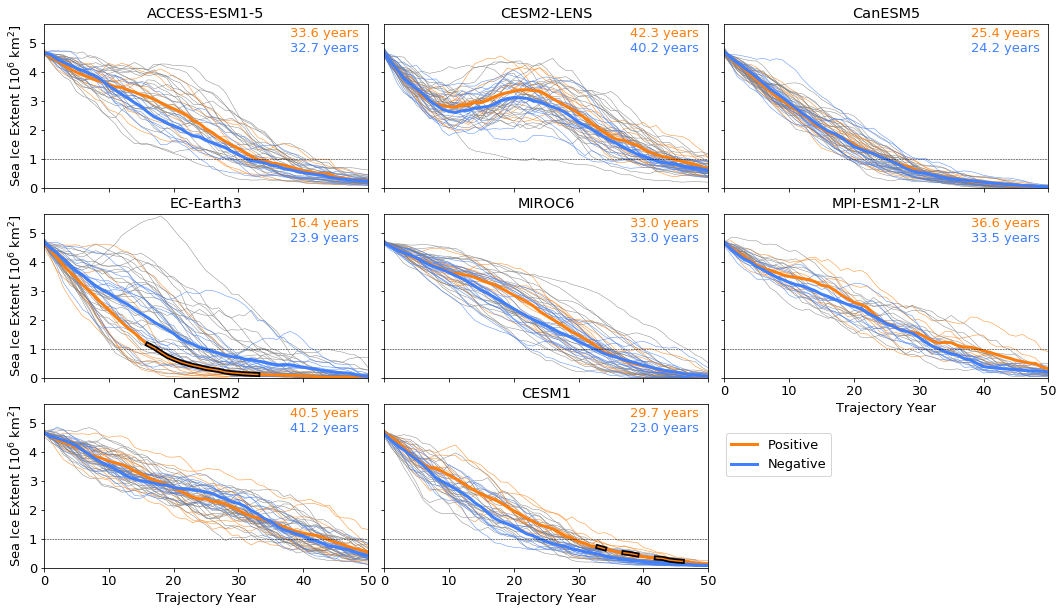

In [26]:
#only plot 8 GCMs' trajectories based on initial IPO phase
pos_col = 'tab:orange'#'tab:orange'
neg_col = [0.25,0.5,1]#'tab:cyan'

fig, axes = plt.subplots(3,3,figsize=[18,10])

for model_i, model_name in enumerate(
    ['ACCESS-ESM1-5', 'CESM2-LENS', 
     'CanESM5', 'EC-Earth3', 'MIROC6',
     'MPI-ESM1-2-LR', 'CanESM2', 'CESM1',]):
    
    ax_x = int(np.floor(model_i / 3))
    ax_y = int(model_i % 3)
    
    pos_mem = IPO_sign[model_name]['member'].where(IPO_sign[model_name]==1, 
                                                   drop=True)
    neu_mem = IPO_sign[model_name]['member'].where(IPO_sign[model_name]==0, 
                                                   drop=True)
    neg_mem = IPO_sign[model_name]['member'].where(IPO_sign[model_name]==-1, 
                                                   drop=True)

    for mem_ in pos_mem:
        axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
            member=mem_), color=pos_col, linewidth=0.5, alpha=0.9)
    for mem_ in neu_mem:
        axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
            member=mem_), color='0.5', linewidth=0.5, alpha=0.9)
    for mem_ in neg_mem:
        axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
            member=mem_), color=neg_col, linewidth=0.5, alpha=0.9)

    #plot the composite for each case
    axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
        member=pos_mem).mean('member'), c=pos_col, linewidth=3, label='Positive')
    axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
        member=neg_mem).mean('member'), c=neg_col, linewidth=3, label='Negative')
    
    #plot a black boarder if statistically significant FROM EACHOTHER
    # t_test = stats.ttest_ind(
    #     SIE_traj[model_name].sel(member=pos_mem),
    #     SIE_traj[model_name].sel(member=neg_mem), axis=0)

    #plot a black boarder if statistically significant FROM MEAN
    t_test_pos = stats.ttest_ind(
        SIE_traj[model_name].sel(member=pos_mem),
        SIE_traj[model_name], axis=0)

    t_test_neg = stats.ttest_ind(
        SIE_traj[model_name].sel(member=neg_mem),
        SIE_traj[model_name], axis=0)
    
   
    axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
        member=pos_mem).mean('member').where(t_test_pos[1]<0.05), c=pos_col,
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
    
    axes[ax_x,ax_y].plot(np.arange(0,51), SIE_traj[model_name].sel(
        member=neg_mem).mean('member').where(t_test_neg[1]<0.05), c=neg_col,
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
    
    #plot text for the first crossing of 1 million square km (Ice-Free)
    ranked_less1 = (SIE_traj[model_name]['time'].where(
        SIE_traj[model_name].sel(member=pos_mem)<1).rank('time'))
    IF_pos = SIE_traj[model_name]['time'].where(ranked_less1==1).max(
        'time').mean()
    ranked_less1 = (SIE_traj[model_name]['time'].where(
        SIE_traj[model_name].sel(member=neg_mem)<1).rank('time'))
    IF_neg = SIE_traj[model_name]['time'].where(ranked_less1==1).max(
        'time').mean()
    
    axes[ax_x,ax_y].text(38,5.2,str(np.round(float(IF_pos),1))+' years',
                         color=pos_col, fontsize=13)
    axes[ax_x,ax_y].text(38,4.7,str(np.round(float(IF_neg),1))+' years',
                         color=neg_col, fontsize=13)

    axes[ax_x,ax_y].axhline(1, c='k', linewidth=0.5, linestyle='--')

    axes[ax_x,ax_y].set_xlim(0,50)
    axes[ax_x,ax_y].set_ylim(0,5.65)
       
    axes[ax_x,ax_y].set_yticks([0,1,2,3,4,5])
    if model_i in [0,3,6]:
        axes[ax_x,ax_y].set_yticklabels(['0','1','2','3','4','5'], fontsize=13)
        axes[ax_x,ax_y].set_ylabel(r'Sea Ice Extent [10$^6$ km$^2$]',
                                   fontsize=13)
    else:
        axes[ax_x,ax_y].set_yticklabels([])
        
    if model_i in [5,6,7]:
        axes[ax_x,ax_y].set_xticks([0,10,20,30,40,50])
        axes[ax_x,ax_y].set_xticklabels(['0','10','20','30','40','50'], 
                                        fontsize=13)
        axes[ax_x,ax_y].set_xlabel('Trajectory Year', fontsize=13)
    else:
        axes[ax_x,ax_y].set_xticks([0,10,20,30,40,50])
        axes[ax_x,ax_y].set_xticklabels([])
    
    
    if model_i == 5:
        axes[ax_x,ax_y].legend(fontsize=13, bbox_to_anchor=(0.35, -0.3))
    
    axes[ax_x,ax_y].set_title(model_name, fontsize=14.5)
    
fig.delaxes(axes[2,2])

plt.subplots_adjust(hspace=0.16, wspace=0.05)
fig.savefig(
    '/glade/work/cwpowell/ice-free/figures/SD_replicate_SIE_4667_TPI_IPO_'\
    'annual_mean_ensemble_anom_standard_11yr_rolling_standard_sig_from_mean.pdf', bbox_inches='tight')

In [ ]:
#N.B. used TOS for EC-Earth3 but TS for all other GCMs as TS not available for EC-Earth3